In [4]:
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import json
from os import listdir
from os.path import isfile, join
from matplotlib import pyplot as plt
import pandas as pd
from sklearn.utils import resample
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier

In [5]:
files = [f for f in listdir("data") if isfile(join("data", f))]
data = []
for file in files:
    with open("data/" + file, "r", encoding='utf-8') as f:
        data += json.load(f)
cleaned = [entry for entry in data if entry[2] < 0] # remove those entries where the ball is flying in the direction of the opponent because we don't do anything in that case anyway.

In [6]:
copy = cleaned.copy()
for entry in copy:
    action = entry[6]
    if action == [1, 0, 0]:
        entry[6] = 'nothing'
    elif action == [0, 1, 0]:
        entry[6] = 'up'
    else:
        entry[6] = 'down'
raw_data = np.array(copy)

In [7]:
data = {'ballX': raw_data[:,0], 'ballY': raw_data[:,1], 'velocityX': raw_data[:,2], 'velocityY': raw_data[:,3], 'paddlePos1': raw_data[:,4], 'paddlePos2': raw_data[:,5], 'action': raw_data[:,6]}
df = pd.DataFrame(data)
df.head()

,ballX,ballY,velocityX,velocityY,paddlePos1,paddlePos2,action
0,0.5,0.5,-0.5000000000000004,-0.8660254037844385,0.5,0.5,nothing
1,0.48125,0.4566987298107781,-0.5000000000000004,-0.8660254037844385,0.5,0.5,nothing
2,0.4625,0.4133974596215561,-0.5000000000000004,-0.8660254037844385,0.5,0.5,nothing
3,0.4437499999999999,0.37009618943233424,-0.5000000000000004,-0.8660254037844385,0.5,0.5,nothing
4,0.42499999999999993,0.3267949192431123,-0.5000000000000004,-0.8660254037844385,0.5,0.5,nothing


In [8]:
df.dtypes

ballX         object
ballY         object
velocityX     object
velocityY     object
paddlePos1    object
paddlePos2    object
action        object
dtype: object

In [9]:
df.ballX = df.ballX.astype(np.float32)
df.ballY = df.ballY.astype(np.float32)
df.velocityX = df.velocityX.astype(np.float32)
df.velocityY = df.velocityY.astype(np.float32)
df.paddlePos1 = df.paddlePos1.astype(np.float32)
df.paddlePos2 = df.paddlePos2.astype(np.float32)
df.action = df.action.astype('category')

In [10]:
df.dtypes

ballX          float32
ballY          float32
velocityX      float32
velocityY      float32
paddlePos1     float32
paddlePos2     float32
action        category
dtype: object

<AxesSubplot:>

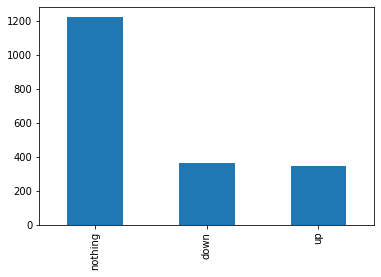

In [11]:
df.action.value_counts().plot(kind='bar')

In [12]:
df_majority = df[df.action == 'nothing']
df_minority1 = df[df.action == 'up']
df_minority2 = df[df.action == 'down']
print(df_majority.shape)
print(df_minority1.shape)
print(df_minority2.shape)
df_majority_downsampled = resample(df_majority, 
                                 replace=False,
                                 n_samples=len(df_minority1),
                                 random_state=42)
df = pd.concat([df_majority_downsampled, df_minority1, df_minority2])
df.action.value_counts()

(1221, 7)
(346, 7)
(363, 7)


down       363
nothing    346
up         346
Name: action, dtype: int64

<AxesSubplot:>

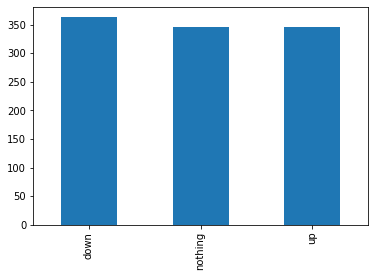

In [13]:
df.action.value_counts().plot(kind='bar')

In [14]:
X = df.drop('action', 1)
y = df['action']

/home/vscode/.local/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  """Entry point for launching an IPython kernel.


In [15]:
X.head()

,ballX,ballY,velocityX,velocityY,paddlePos1,paddlePos2
878,0.500000,0.500000,-0.939693,-0.342020,0.500000,0.500000
413,0.391858,0.458654,-0.961262,-0.275637,0.500000,0.500000
75,0.968750,0.803109,-0.500000,0.866025,0.666667,0.666667
1622,0.088905,0.255958,-0.913545,-0.406737,0.250000,0.250000
1208,0.838646,0.392099,-0.694658,-0.719340,0.541667,0.541667


In [16]:
y.head()

878     nothing
413     nothing
75      nothing
1622    nothing
1208    nothing
Name: action, dtype: category
Categories (3, object): ['down', 'nothing', 'up']

In [17]:
y.values

['nothing', 'nothing', 'nothing', 'nothing', 'nothing', ..., 'down', 'down', 'down', 'down', 'down']
Length: 1055
Categories (3, object): ['down', 'nothing', 'up']

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [19]:
scaler = StandardScaler()
scaler.fit(X_train)
scaler.transform(X_train)
scaler.transform(X_test)

array([[-0.8274886 , -0.25488177, -1.3991463 , -0.04858106, -0.37722465,
        -0.37722465],
       [-0.04080316, -0.39001167, -1.0098118 , -0.5940143 , -0.19350986,
        -0.19350986],
       [-0.4452511 , -1.1320022 , -0.02550229, -1.0490594 ,  1.6436371 ,
         1.6436371 ],
       ...,
       [ 1.2838287 ,  1.6257343 ,  0.6206854 , -1.2281241 ,  0.90877813,
         0.90877813],
       [-1.4228243 ,  1.3018696 ,  0.46828625, -1.1907568 ,  1.8273518 ,
         1.8273518 ],
       [ 0.12878363, -0.32342294, -1.0098118 , -0.5940143 , -0.00979522,
        -0.00979522]], dtype=float32)

In [20]:
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train, y_train)
dummy_clf.predict(X_test)
dummy_clf.score(X_test, y_test)

0.32701421800947866

In [21]:
estimator_KNN = KNeighborsClassifier(algorithm='auto')

In [22]:
parameters_KNN = {
    'n_neighbors': (1, 2, 4, 8, 10, 12, 16, 24),
    'leaf_size': (1, 4, 8, 12, 16, 20),
    'p': (1,2),
    'weights': ('uniform', 'distance'),
    'metric': ('minkowski', 'chebyshev')}
                   
grid_search_KNN = GridSearchCV(
    estimator=estimator_KNN,
    param_grid=parameters_KNN,
    scoring = 'f1_micro',
    n_jobs = -1,
    cv = 5
)
grid_search_KNN.fit(X_train, y_train)
print(grid_search_KNN.best_params_ )
print('Best Score - KNN:', grid_search_KNN.best_score_ )

{'leaf_size': 12, 'metric': 'minkowski', 'n_neighbors': 1, 'p': 1, 'weights': 'uniform'}
Best Score - KNN: 0.8175542406311637


In [23]:
knn = KNeighborsClassifier(leaf_size=12, metric='minkowski', n_neighbors=1, p=1, weights='uniform')
knn.fit(X_train, y_train)

KNeighborsClassifier(leaf_size=12, n_neighbors=1, p=1)

In [24]:
y_pred = grid_search_KNN.predict(X_test)

In [25]:
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='micro')
print ("test accuracy score: %.2f" % accuracy)
print ("test f1 score: %.2f" % f1)

test accuracy score: 0.78
test f1 score: 0.78


In [26]:
random_forest = RandomForestClassifier(random_state=42)
parameters_RandomForest = {
    'n_estimators': [10, 25, 250],
    'max_features': ['sqrt', 0.25, 0.5, 0.75, 1.0],
    'min_samples_split': [1, 4, 8, 16]
}
                   
grid_search_RandomForest = GridSearchCV(
    estimator=random_forest,
    param_grid=parameters_RandomForest,
    scoring = 'f1_micro',
    n_jobs = -1,
    cv = 5
)
grid_search_RandomForest.fit(X_train, y_train)
print(grid_search_RandomForest.best_params_ )
print('Best Score - Random Forest:', grid_search_RandomForest.best_score_ )

/home/vscode/.local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/vscode/.local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/vscode/.local/lib/python3.7/site-packages/sklearn/ensemble/_forest.py", line 393, in fit
    for i, t in enumerate(trees))
  File "/home/vscode/.local/lib/python3.7/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/home/vscode/.local/lib/python3.7/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/home/vscode/.local/lib/python3.7/site-packages/joblib/parallel.py", line 779, in _dispatch
    job = self._backend.apply_async(batch, callback=cb

{'max_features': 0.25, 'min_samples_split': 4, 'n_estimators': 250}
Best Score - Random Forest: 0.8033882783882784


In [27]:
y_pred = grid_search_RandomForest.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='micro')
print ("test accuracy score: %.2f" % accuracy)
print ("test f1 score: %.2f" % f1)

test accuracy score: 0.79
test f1 score: 0.79


In [28]:
!pip install auto-sklearn

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.


In [29]:
from autosklearn.experimental.askl2 import AutoSklearn2Classifier

In [30]:
automl = AutoSklearn2Classifier(time_left_for_this_task=5*60, per_run_time_limit=30, n_jobs=8)
automl.fit(X_train, y_train)
y_hat = automl.predict(X_test)
print("Accuracy score", accuracy_score(y_test, y_hat))

Accuracy score 0.8199052132701422
